## CAE Trainer on MNIST

In [2]:
import numpy as np
import argparse
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy
from scipy import misc
import os
import shutil
from random import randint
import matplotlib.pyplot as plt

In [5]:
NUM_LABELS = 47
rnd = np.random.RandomState(123)
tf.set_random_seed(123)
batch_size = 128
IMG_CHN = 1

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 28, 28)


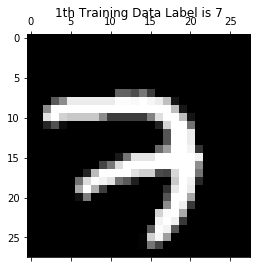

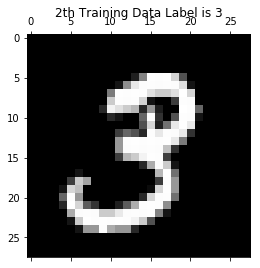

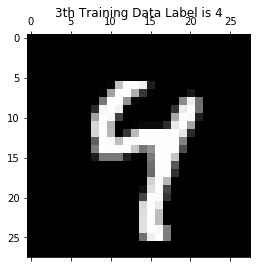

In [7]:
trainimg = mnist.train.images
train_X = trainimg.reshape([-1,28,28])
trainlabel = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(trainlabel[i, :] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))
IMAGE_SIZE = train_X.shape
print(IMAGE_SIZE)

In [8]:
##define utils
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

def upsample(input, name, factor=[2,2]):
    size = [int(input.shape[1] * factor[0]), int(input.shape[2] * factor[1])]
    with tf.name_scope(name):
        out = tf.image.resize_nearest_neighbor(input, size=size, align_corners=False, name=None)
        return out

In [9]:
def encoder(x, reuse = False):
    
    c1 = slim.convolution2d(x, 32, [3,3], stride=[1,1], padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='conv1')
    
    p1 = slim.max_pool2d(c1, [2, 2], scope='pool1')
    
    c2 = slim.convolution2d(p1, 64, [3,3], stride=[2,2], padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='conv2')
    
    c3 = slim.convolution2d(c2, 64, [3,3], stride=[1,1], padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='conv3')

    e_out = slim.max_pool2d(c3, [2, 2], scope='pool2')
    
    print(e_out.shape)
    return e_out

In [10]:
def decoder(f, reuse = False):
    
    up1 = upsample(f, name = "up1")

    dc_1 = slim.convolution2d_transpose(\
        up1,num_outputs=64, kernel_size=[3,3],stride=[1,1],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='dconv_1' )

    dc_2 = slim.convolution2d_transpose(\
        dc_1, num_outputs=32, kernel_size=[3,3],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='dconv_2' )

    up2 = upsample(dc_2, name = "up2")

    dc_3 = slim.convolution2d_transpose(\
        up2, num_outputs=IMG_CHN, kernel_size=[3,3],stride=[1,1],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.sigmoid,scope='dconv_3' )

    print(dc_3.shape)
    return dc_3


In [11]:
#set computational graph

tf.reset_default_graph()
img_in = tf.placeholder(shape = [None, 32, 32, IMG_CHN], dtype = tf.float32)

fx = encoder(img_in)
#print(fx.shape)
xp = decoder(fx)

loss = tf.reduce_mean(tf.square(tf.subtract(xp, img_in)))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5).minimize(loss)

(?, 4, 4, 64)
(?, 32, 32, 1)


In [14]:
#train

batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 5000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for i in range(iterations):
        
        xs,_ = mnist.train.next_batch(batch_size)
        xs = (np.reshape(xs,[batch_size,28,28,1]) ) 
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
        _,train_loss, x_re = sess.run([optimizer, loss, xp], feed_dict = {img_in:xs})
        
        if i % 10 == 0:
            print("iter:{} reconstructive loss:{}".format(i,train_loss))

            if not os.path.exists(sample_directory):
                    os.makedirs(sample_directory)
        
            #save_images(x_re, [32,32] ,sample_directory+'/fig'+str(i)+'.png')
            save_images(np.reshape(x_re[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
            if i % 1000 == 0 and i != 0:
                if not os.path.exists(model_directory):
                    os.makedirs(model_directory)
                saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
                print("Saved Model")

iter:0 reconstructive loss:0.6991549730300903


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


iter:10 reconstructive loss:0.5385639667510986
iter:20 reconstructive loss:0.5334188938140869
iter:30 reconstructive loss:0.529035210609436
iter:40 reconstructive loss:0.5234220027923584
iter:50 reconstructive loss:0.520530104637146
iter:60 reconstructive loss:0.5151888132095337
iter:70 reconstructive loss:0.514736533164978
iter:80 reconstructive loss:0.5109316110610962
iter:90 reconstructive loss:0.506068766117096
iter:100 reconstructive loss:0.5008804202079773
iter:110 reconstructive loss:0.5022404193878174
iter:120 reconstructive loss:0.4984365701675415
iter:130 reconstructive loss:0.4930884838104248
iter:140 reconstructive loss:0.4934900999069214
iter:150 reconstructive loss:0.48814064264297485
iter:160 reconstructive loss:0.48563796281814575
iter:170 reconstructive loss:0.48195910453796387
iter:180 reconstructive loss:0.4817362427711487
iter:190 reconstructive loss:0.47923800349235535
iter:200 reconstructive loss:0.4783852696418762
iter:210 reconstructive loss:0.4760950207710266
i

iter:1690 reconstructive loss:0.3055158257484436
iter:1700 reconstructive loss:0.30510789155960083
iter:1710 reconstructive loss:0.30444639921188354
iter:1720 reconstructive loss:0.3040725290775299
iter:1730 reconstructive loss:0.3037272095680237
iter:1740 reconstructive loss:0.30314821004867554
iter:1750 reconstructive loss:0.30300599336624146
iter:1760 reconstructive loss:0.3025512099266052
iter:1770 reconstructive loss:0.30201685428619385
iter:1780 reconstructive loss:0.3015842139720917
iter:1790 reconstructive loss:0.30145689845085144
iter:1800 reconstructive loss:0.3008890748023987
iter:1810 reconstructive loss:0.3005110025405884
iter:1820 reconstructive loss:0.300409734249115
iter:1830 reconstructive loss:0.29975390434265137
iter:1840 reconstructive loss:0.2993970215320587
iter:1850 reconstructive loss:0.29910844564437866
iter:1860 reconstructive loss:0.2987583875656128
iter:1870 reconstructive loss:0.2981300354003906
iter:1880 reconstructive loss:0.297815203666687
iter:1890 reco

iter:3350 reconstructive loss:0.2717318534851074
iter:3360 reconstructive loss:0.2710052728652954
iter:3370 reconstructive loss:0.27233219146728516
iter:3380 reconstructive loss:0.2714363932609558
iter:3390 reconstructive loss:0.27307552099227905
iter:3400 reconstructive loss:0.27155426144599915
iter:3410 reconstructive loss:0.27121204137802124
iter:3420 reconstructive loss:0.2705214321613312
iter:3430 reconstructive loss:0.272163987159729
iter:3440 reconstructive loss:0.27083253860473633
iter:3450 reconstructive loss:0.27075058221817017
iter:3460 reconstructive loss:0.2712263762950897
iter:3470 reconstructive loss:0.2709067761898041
iter:3480 reconstructive loss:0.27263015508651733
iter:3490 reconstructive loss:0.26961201429367065
iter:3500 reconstructive loss:0.2708171606063843
iter:3510 reconstructive loss:0.2708665132522583
iter:3520 reconstructive loss:0.2705356478691101
iter:3530 reconstructive loss:0.27182847261428833
iter:3540 reconstructive loss:0.27122825384140015
iter:3550 r

In [16]:
#infer

sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36


saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
     #Generate a random z batch
    xs,_ = mnist.validation.next_batch(batch_size)
    xs = (np.reshape(xs,[batch_size,28,28,1]) ) 
    xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
    x_re = sess.run(xp,feed_dict={img_in:xs}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(x_re[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/infer.png')

Loading Model...
INFO:tensorflow:Restoring parameters from ./models\model-4000.cptk


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app
